Dataset: https://www.kaggle.com/competitions/dogs-vs-cats/data


## Importing the libraries


In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

%matplotlib inline

## Loading the data


In [2]:
filenames = os.listdir("data/train")
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == "cat":
        categories.append("cat")
    else:
        categories.append("dog")

df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

In [3]:
df.head()

filename category
0     cat.0.jpg      cat
1     cat.1.jpg      cat
2    cat.10.jpg      cat
3   cat.100.jpg      cat
4  cat.1000.jpg      cat

In [4]:
df['category'].value_counts()

category
cat    12500
dog    12500
Name: count, dtype: int64

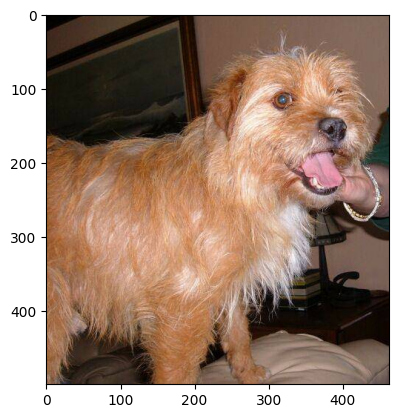

In [5]:
sample = random.choice(filenames)
image = load_img(f"data/train/{sample}")

plt.imshow(image)
plt.show()

## Building the model


In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, padding="same", kernel_size=3, activation="relu", strides=2, input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, padding="same", kernel_size=3, activation="relu", strides=2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, padding="same", kernel_size=3, activation="relu", strides=2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, kernel_regularizer=l2(0.01), activation="linear"))

model.compile(optimizer="adam", loss="hinge", metrics=["accuracy"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

## Callbacks


In [8]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Preparing the data


In [9]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [10]:
train_df['category'].value_counts()

category
dog    10015
cat     9985
Name: count, dtype: int64

In [11]:
validate_df['category'].value_counts()

category
cat    2515
dog    2485
Name: count, dtype: int64

### Training generator


In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "data/train",
    x_col="filename",
    y_col="category",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation generator


In [13]:
validate_datagen = ImageDataGenerator(rescale=1./255)

validate_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    "data/train",
    x_col="filename",
    y_col="category",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

Found 5000 validated image filenames belonging to 2 classes.


### Visualizing generator


In [14]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "data/train",
    x_col="filename",
    y_col="category",
    target_size=(128, 128),
    class_mode="categorical"
)

Found 1 validated image filenames belonging to 1 classes.


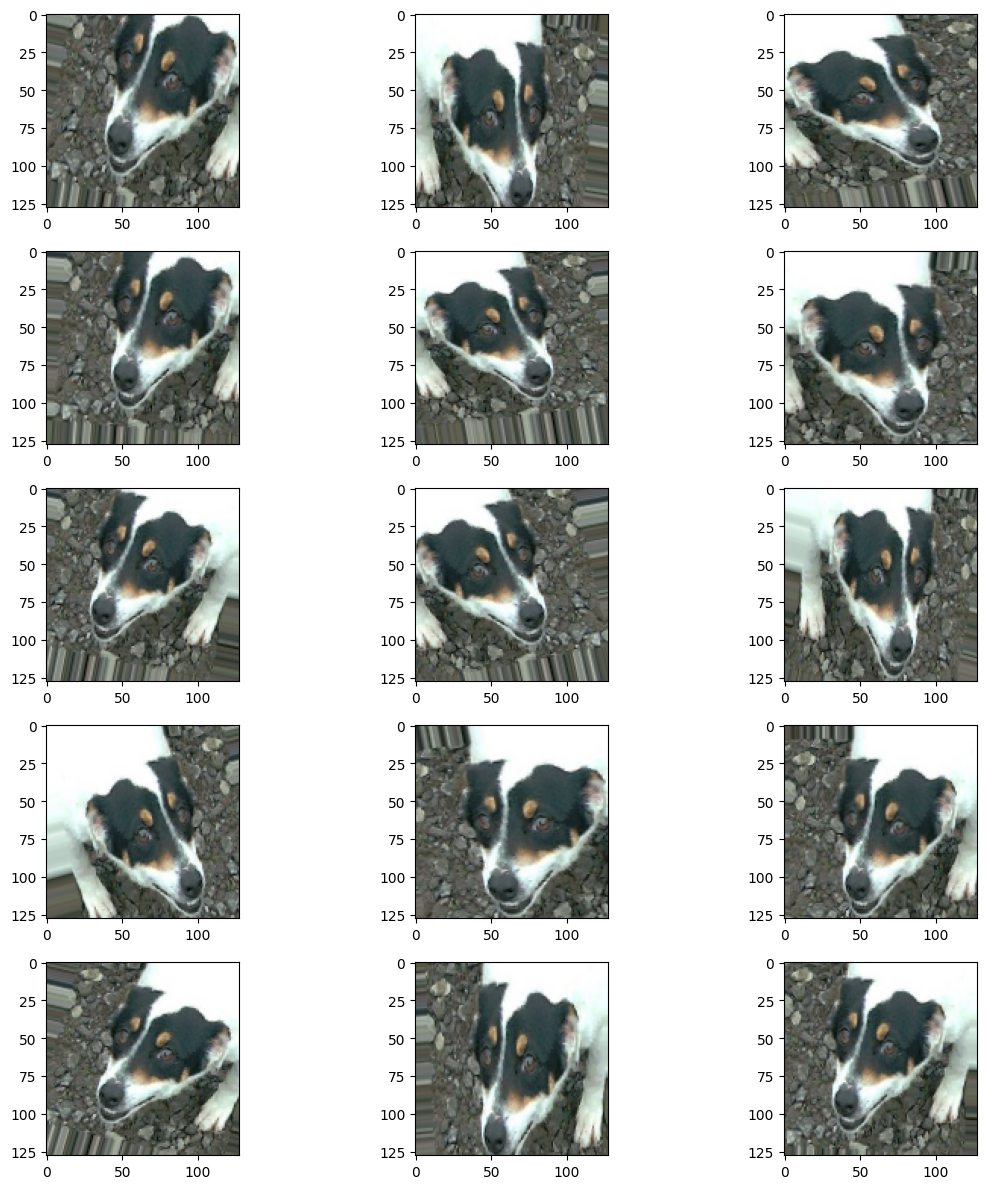

In [15]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

## Fitting the model


In [16]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validate_generator,
    validation_steps=validate_df.shape[0]//32,
    steps_per_epoch=train_df.shape[0]//32,
    callbacks=callbacks
)

Epoch 1/50


625/625 [==============================] - 203s 317ms/step - loss: 0.9831 - accuracy: 0.5956 - val_loss: 0.7719 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 169s 271ms/step - loss: 0.7704 - accuracy: 0.6478 - val_loss: 0.9735 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 170s 271ms/step - loss: 0.7089 - accuracy: 0.6782 - val_loss: 0.6487 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 170s 271ms/step - loss: 0.6704 - accuracy: 0.6926 - val_loss: 0.6950 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 169s 270ms/step - loss: 0.6401 - accuracy: 0.7064 - val_loss: 0.6181 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 170s 271ms/step - loss: 0.6118 - accuracy: 0.7207 - val_loss: 0.6126 - val_accuracy: 0.7163 - lr: 0.0010
Epoch 7/50
625/625 [========================

In [17]:
model.save_weights("model.h5")

## Visualizing training


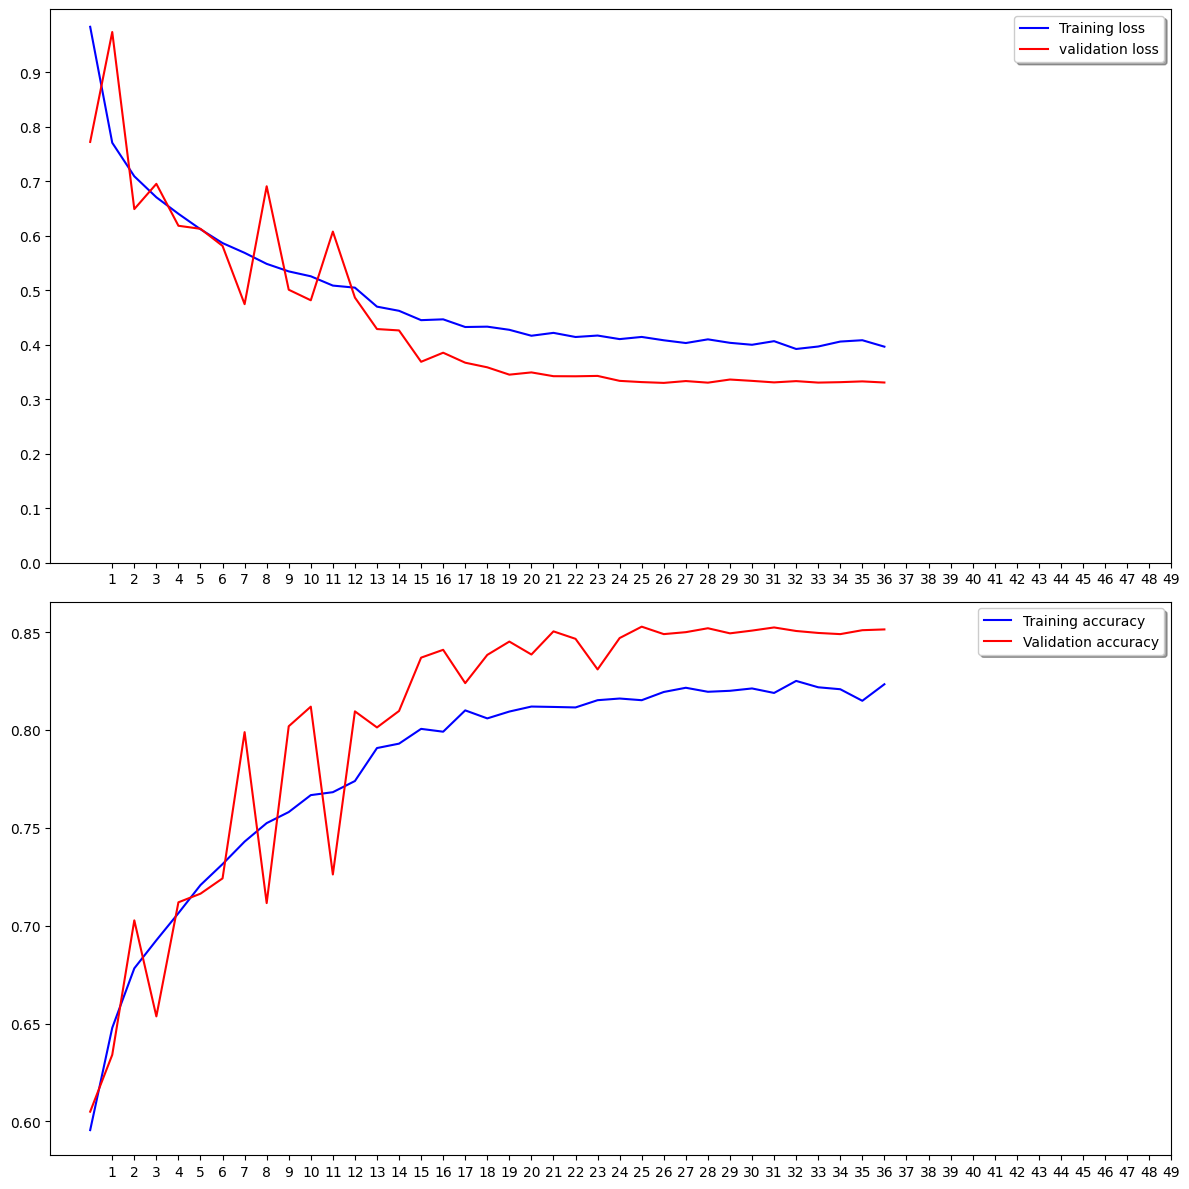

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

## Final steps


### Preparing the test data


In [19]:
filenames = os.listdir("data/test")

test_df = pd.DataFrame({
    'filename': filenames
})

### Creating test generator


In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "data/test",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size=32,
    shuffle=False
)

Found 12500 validated image filenames.


### Making predictions


In [21]:
predict = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/32))

391/391 [==============================] - 43s 110ms/step


In [22]:
categories = []

for pred in predict:
    if pred[0] < 0:
        categories.append("cat")
    else:
        categories.append("dog")

test_df["category"] = categories

In [23]:
test_df.head()

filename category
0      1.jpg      dog
1     10.jpg      cat
2    100.jpg      cat
3   1000.jpg      dog
4  10000.jpg      dog

In [24]:
test_df["category"].value_counts()

category
dog    6278
cat    6222
Name: count, dtype: int64

### Visualizing predictions


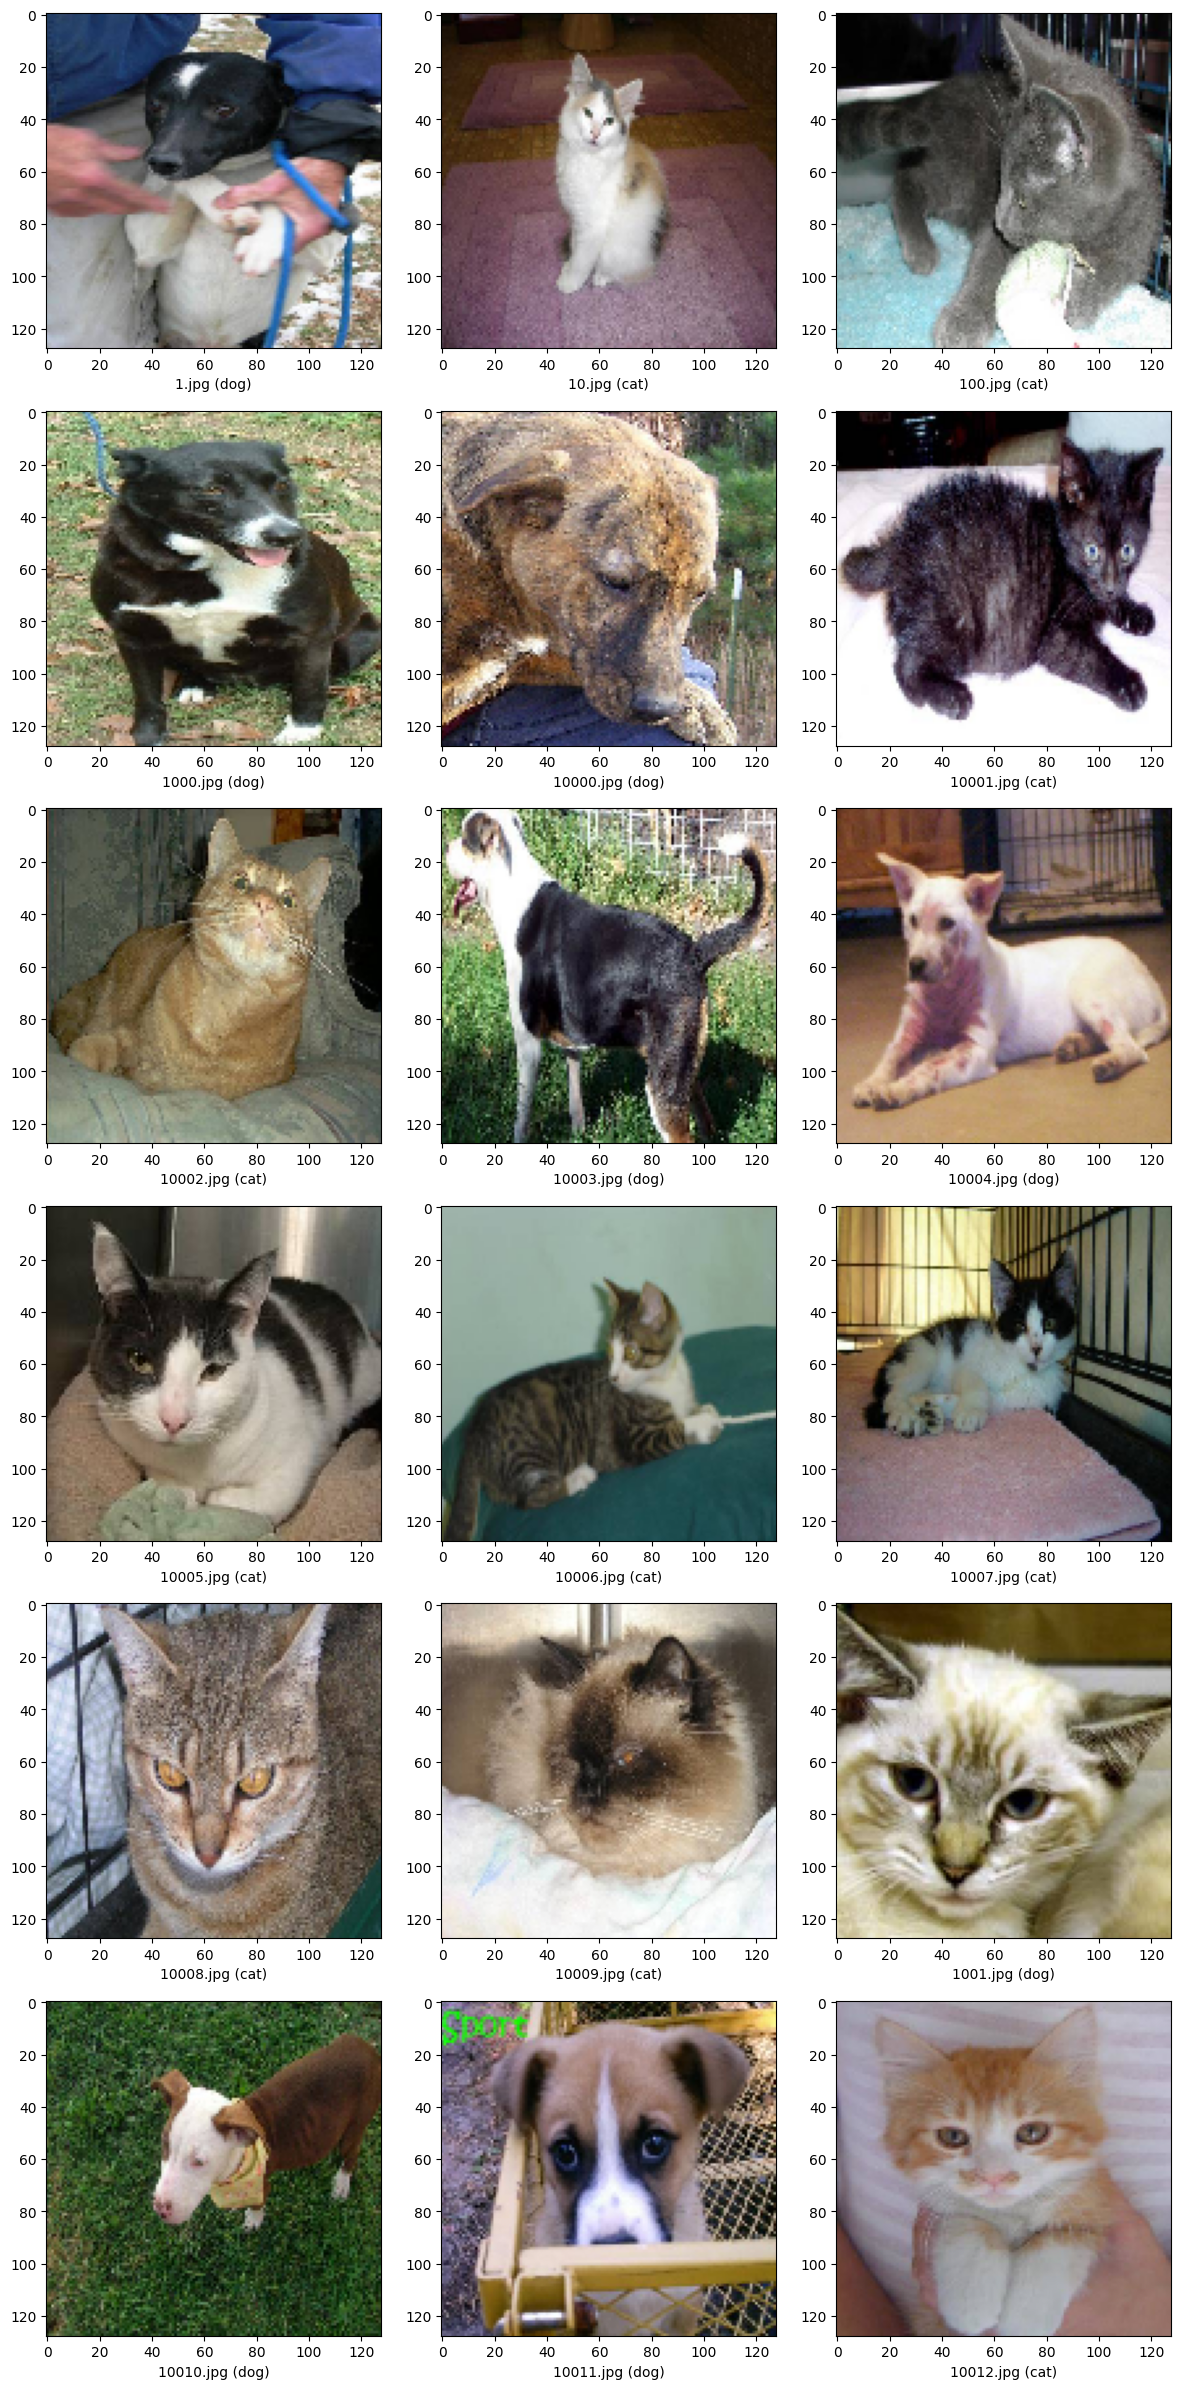

In [25]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for idx, row in sample_test.iterrows():
    filename = row["filename"]
    category = row["category"]

    img = load_img(f"data/test/{filename}", target_size=(128, 128))
    plt.subplot(6, 3, idx+1)

    plt.imshow(img)
    plt.xlabel(f"{filename} ({category})")

plt.tight_layout()
plt.show()